# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import project_tests as t
import pickle

%matplotlib inline
#import progressbar
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


import project_tests as t

# optional section for nltk packages
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download(['punkt', 'wordnet', 'stopwords',
               'averaged_perceptron_tagger'])


df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


article_id                                              title  \
0      1430.0  using pixiedust for fast, flexible, and easier...   
1      1314.0       healthcare python streaming application demo   
2      1429.0         use deep learning for image classification   
3      1338.0          ml optimization using cognitive assistant   
4      1276.0          deploy your python model as a restful api   

                                      email  
0  ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7  
1  083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b  
2  b96a4f2e92d8572034b1e9b28f9ac673765cd074  
3  06485706b34a5c9bf2a0ecdac41daf7e7654ceb7  
4  f01220c46fc92c6e6b161b1849de11faacd7ccb2

In [2]:
# Show df_content to get an idea of the data
df_content.head()

doc_body  \
0  Skip navigation Sign in SearchLoading...\r\n\r...   
1  No Free Hunch Navigation * kaggle.com\r\n\r\n ...   
2  ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...   
3  DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...   
4  Skip navigation Sign in SearchLoading...\r\n\r...   

                                     doc_description  \
0  Detect bad readings in real time using Python ...   
1  See the forest, see the trees. Here lies the c...   
2  Here’s this week’s news in Data Science and Bi...   
3  Learn how distributed DBs solve the problem of...   
4  This video demonstrates the power of IBM DataS...   

                                       doc_full_name doc_status  article_id  
0  Detect Malfunctioning IoT Sensors with Streami...       Live           0  
1  Communicating data science: A guide to present...       Live           1  
2         This Week in Data Science (April 18, 2017)       Live           2  
3  DataLayer Conference: Boost the performance of...       Live           3  
4      Analyze NY Restaurant data using Spark in DSX       Live           4

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

Provide a visual and a descriptive statistics to assist with giving a look at the number of times each user interacts with an article

In [3]:
# Total distribution of how many articles a user interacts
#Assumption: user = distinct email
#number of articles = distinct articles id 
dist = df['article_id'].value_counts()

In [4]:
#Look at the number of times each user interacts with an article
user = df['email'].value_counts()

#Top 10 of distribution
top_10_user = user.iloc[0:10]
top_10_user

2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
f8c978bcf2ae2fb8885814a9b85ffef2f54c3c76    158
284d0c17905de71e209b376e3309c0b08134f7e2    148
18e7255ee311d4bd78f5993a9f09538e459e3fcc    147
d9032ff68d0fd45dfd18c0c5f7324619bb55362c    147
c60bb0a50c324dad0bffd8809d121246baef372b    145
Name: email, dtype: int64

It seems there are two users that have a pretty high frequency with 364 and 363. After those two users there is a larger gap with the next users having 170 counts and less.

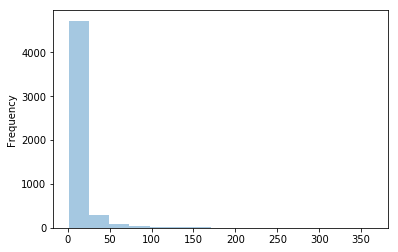

In [5]:
#Visual representation
#Goal is a bar chart 
#on x-axis = articles_id and on y-axis = number of distinct emails -> Frequency

ax = user.plot.hist(bins=15, alpha=0.4)

Most users are around 0 and 50 articles while there are some outliers above 100 articles.

In [6]:
mean_user = user.mean()
mean_user

8.9308469308469309

The mean is around 9 articles per user

In [7]:
median_user = user.median()
median_user

3.0

The median is 3 articles per user

In [8]:
max_user = user.max()
max_user

364

The maximum is 364 articles for one user.

In [9]:
# Fill in the median and maximum number of user_article interactios below
median_val = 3# 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364# The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [10]:
# Find and explore duplicate articles
df_content.head()

doc_body  \
0  Skip navigation Sign in SearchLoading...\r\n\r...   
1  No Free Hunch Navigation * kaggle.com\r\n\r\n ...   
2  ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...   
3  DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...   
4  Skip navigation Sign in SearchLoading...\r\n\r...   

                                     doc_description  \
0  Detect bad readings in real time using Python ...   
1  See the forest, see the trees. Here lies the c...   
2  Here’s this week’s news in Data Science and Bi...   
3  Learn how distributed DBs solve the problem of...   
4  This video demonstrates the power of IBM DataS...   

                                       doc_full_name doc_status  article_id  
0  Detect Malfunctioning IoT Sensors with Streami...       Live           0  
1  Communicating data science: A guide to present...       Live           1  
2         This Week in Data Science (April 18, 2017)       Live           2  
3  DataLayer Conference: Boost the performance of...       Live           3  
4      Analyze NY Restaurant data using Spark in DSX       Live           4

In [3]:
# check number of duplicates
print('The amount of duplicates is ', sum(df_content["article_id"].duplicated()), 'in the dataset')

The amount of duplicates is  5 in the dataset


In [5]:
counts = df_content["article_id"].value_counts()

In [15]:
# Remove any rows that have the same article_id - only keep the first

In [6]:
df_content["article_id"].drop_duplicates(inplace = True)

In [7]:
#double check the duplicates:
print('The amount of duplicates is ', sum(df_content["article_id"].duplicated()), 'in the dataset')

The amount of duplicates is  0 in the dataset


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [15]:
#a.The number of unique articles that have an interaction with a user.
id_count = df["article_id"].unique() 
num_articles = len(id_count)
num_articles

714

In [16]:
#b. The number of unique articles in the dataset (whether they have any interactions or not).
null_values = df[df["email"]==""]
null_values

Empty DataFrame
Columns: [article_id, title, email]
Index: []

In [17]:
all_articles = df_content["article_id"].unique()
all = len(all_articles)
all
#all_articles.sort()
#all_articles

1051

All articles contain 1051 article IDs.

In [18]:
#c. The number of unique users in the dataset. (excluding null values) 
users = df["email"].unique() 
num_users = len(users)
num_users

5149

In [19]:
#d. The number of user-article interactions in the dataset.
dist = df['article_id'].value_counts()
dist.sum()

45993

In [20]:
unique_articles = 714 #number of unique articles that have an interaction with a user
total_articles =  1051# The number of unique articles on the IBM platform
unique_users = 5148# The number of unique users
user_article_interactions = 45993# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [21]:
dist = df['article_id'].value_counts()
dist.head()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64

In [22]:
most_viewed_article_id = "1429.0"# The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937# The most viewed article in the dataset was viewed how many times?

In [3]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

article_id                                              title  user_id
0      1430.0  using pixiedust for fast, flexible, and easier...        1
1      1314.0       healthcare python streaming application demo        2
2      1429.0         use deep learning for image classification        3
3      1338.0          ml optimization using cognitive assistant        4
4      1276.0          deploy your python model as a restful api        5

In [24]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [4]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df['title'].value_counts()
    top_articles = top_articles.index.tolist()
    top_articles = top_articles[:n]
    
    
    return top_articles 

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df['article_id'].value_counts()
    top_articles = top_articles.index.tolist()
    top_articles = top_articles[:n]
 
    return top_articles # Return the top article ids

In [7]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [8]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [5]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - A pandas dataframe with three columns: article_id, title, user_id columns
    
    OUTPUT:
    A user item matrix 
    
    Description:
    It returns a matrix with user ids on the row count and article ids on the column section.
    It returns a "1" if a user interacted with an article and "0" without any interaction.
    '''
    
    #create empty dataframe:
    #on row level: user_id.unique
    user_id_unique = df["user_id"].unique()
    #on column level: article_id.unique
    article_id_unique = df["article_id"].unique()
    
    #fill values for row and column
    user_item = pd.DataFrame(columns=article_id_unique, index=user_id_unique)
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().notnull().unstack()
    #replace NaN values with 0 values
    user_item = user_item.notnull().astype('int')
    
    return user_item

user_item = create_user_item_matrix(df)

In [6]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [7]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    
    # Compute the dot product
    similar_raw = user_item.iloc[user_id -1 :user_id,:].dot(user_item.T)

    # sort by similarity
    similar = similar_raw.sort_values(by = user_id, axis = 1, ascending = False)

    # create list of just the ids
    most_similar_users =list(similar.columns) 
   
    # remove the own user's id
    most_similar_users.remove(user_id)
    return most_similar_users # return a list of the users in order from most to least similar
        

In [8]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [9]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    
    df_sub = df[['article_id','title']].drop_duplicates(subset=['article_id'])
    df_sub_new = df_sub[df_sub['article_id'].isin(article_ids)]
    article_names = list(df_sub_new["title"])
    
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    
    #####
    user_list_raw = user_item[user_item.index==user_id]
    cols = user_list_raw.columns
    user_list_raw = user_list_raw[user_list_raw[cols]==1]
    user_list_raw = user_list_raw.dropna(how='all', axis=1)
    user_list = list(user_list_raw)
    article_ids = user_list
    #article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.tolist()
    for x in range(0, len(article_ids)):
        article_ids[x] = str(article_ids[x])
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    
    recs = []
    viewed_articles = get_user_articles(50)
    similar_user_id = find_similar_users(50)
    for user_id in similar_user_id:
        article_ids, article_names = get_user_articles(user_id)
        recs = list(set().union(recs, article_ids)) 
        if len(recs) >= 10:
            break
    return recs[:m]  

In [10]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['10 must attend data science, ml and ai conferences in 2018',
 'use apache systemml and spark for machine learning',
 'analyze open data sets with spark & pixiedust',
 'analyzing data by using the sparkling.data library features',
 '5 practical use cases of social network analytics: going beyond facebook and twitter',
 'a comparison of logistic regression and naive bayes ',
 'ensemble learning to improve machine learning results',
 'data science bowl 2017',
 'tidyverse practice: mapping large european cities',
 '51822    using apache spark as a parallel processing fr...\nName: title, dtype: object']

In [11]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [12]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id as integer
    df as a pandas dataframe. 
         
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
                         
    '''
    # Your code here
    
    # create expected dataframe
    neighbors_df = pd.DataFrame(columns = 
                                ['neighbor_id', 
                                 'similarity', 
                                 'num_interactions'])
    
    #fill up the neighbors_df
    for user in user_item.index.values:
        if user != user_id:
            neighbor_id = user
            
            #number of interactions
            num_interactions = df.groupby(['user_id'])['article_id'].count()
            #similarity as dot product
            similarity = user_item[user_item.index == user_id].dot(user_item.loc[user].T).values[0]
            
            #neighbor_id
            neighbors_df.loc[neighbor_id] = [neighbor_id, similarity, num_interactions]
    
        #sort neighbor_df by similarity and then by neighbor_id
        neighbors_df = neighbors_df.sort_values(by = ['similarity', 'neighbor_id'], ascending = [False, True])
    
    return neighbors_df # Return the dataframe specified in the doc_string
    

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = []
    rec_names = []
    top_sorted_df = get_top_sorted_users(user_id)
    viewed_article_ids = get_user_articles(user_id)[0]
    
    for neighbor in top_sorted_df['neighbor_id']:
        if len(recs) > m:
                    break
        for article_id in get_user_articles(neighbor)[0]:
            if article_id not in viewed_article_ids:
                if len(recs) > m:
                    break
                else:
                    recs.append(article_id)
    rec_names = get_article_names(recs) 
    
    return recs, rec_names

In [13]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['43.0', '109.0', '111.0', '112.0', '164.0', '213.0', '225.0', '313.0', '337.0', '379.0', '482.0']

The top 10 recommendations for user 20 are the following article names:
['deep learning with tensorflow course by big data university', 'learn tensorflow and deep learning together and now!', 'tidy up your jupyter notebooks with scripts', 'tensorflow quick tips', 'modeling energy usage in new york city', 'using deep learning with keras to predict customer churn', 'data structures related to machine learning algorithms', 'what is machine learning?', 'a visual explanation of the back propagation algorithm for neural networks', 'building custom machine learning algorithms with apache systemml', 'generalization in deep learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

Calculation for user 1 and user 131

In [18]:
user1_most_sim = get_top_sorted_users(1)
user1 = user1_most_sim.index[0]
user1

3933

In [75]:
user131_10th_sim = get_top_sorted_users(131)
user131 = user131_10th_sim.index[9]
user131

242

In [76]:
user1_most_sim = 3933# Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [77]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

My response:
If we were given a new user, I would only recommend the first M amount of articles that have been most used within the whole population.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [14]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to

#number of recommendations
m = 10
user_0 = get_top_article_ids(m)
for art in range(0, len(user_0)):
        user_0[art] = str(user_0[art])
user_0_recs = user_0

new_user_recs = user_0_recs# Your recommendations here



In [15]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [20]:
def tokenize(text):
    """Function to tokenize an article title

    Args:
        text (str) title

    return:
        tokens (list) a list of words

    """

    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

    # tokenize text
    tokens = word_tokenize(text)

    # lemmatize and remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens
              if word not in stop_words]
    # remove short words
    tokens = [token for token in tokens if len(token) > 2]

    return tokens

In [21]:
df_extra = pd.read_csv('data/user-item-interactions.csv')
df_content_extra = pd.read_csv('data/articles_community.csv')
del df_extra['Unnamed: 0']
del df_content_extra['Unnamed: 0']

# Show df to get an idea of the data
df_extra.head()

article_id                                              title  \
0      1430.0  using pixiedust for fast, flexible, and easier...   
1      1314.0       healthcare python streaming application demo   
2      1429.0         use deep learning for image classification   
3      1338.0          ml optimization using cognitive assistant   
4      1276.0          deploy your python model as a restful api   

                                      email  
0  ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7  
1  083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b  
2  b96a4f2e92d8572034b1e9b28f9ac673765cd074  
3  06485706b34a5c9bf2a0ecdac41daf7e7654ceb7  
4  f01220c46fc92c6e6b161b1849de11faacd7ccb2

In [22]:
def create_article_content_dataframe(df=df, df_content=df_content):
    '''
    INPUT:
    df - pandas dataframe describing user interaction with the articles
    df_content - pandas dataframe describing articles on the platform
    OUTPUT:
    df_total - pandas dataframe containing all articles in the platform
    article_content -  pandas dataframe describe the content of each
                       article on the platform

    Description:
    Return a pandas dataframe containing all articles on the platform
    with its titles and a pandas dataframe describing the content of each
    article based on the article title.
    '''

    # Get a dataframe of the full articles
    df_1 = df_extra[['article_id', 'title']]
    df_2 = pd.DataFrame({'article_id': df_content_extra.article_id.values,
                         'title': df_content_extra. doc_full_name})
    df_total = pd.concat([df_1, df_2], ignore_index=True)
    df_total.drop_duplicates(subset=['article_id'], inplace=True)
    df_total.sort_values(by='article_id', inplace=True)
    df_total.reset_index(drop=True, inplace=True)

    # TfidfVectorizer
    vectorizer = TfidfVectorizer(tokenizer=tokenize)
    df_vec = pd.DataFrame(vectorizer.fit_transform(
                          df_total.title.values).toarray(),
                          columns=[*vectorizer.vocabulary_])

    # concat  df_total and df_vec
    #df_articles = df_vec
    df_articles = pd.concat([df_total, df_vec], axis=1)

    return df_total, df_articles


df_total, df_articles = create_article_content_dataframe()

In [23]:
df_extra.head()

article_id                                              title  \
0      1430.0  using pixiedust for fast, flexible, and easier...   
1      1314.0       healthcare python streaming application demo   
2      1429.0         use deep learning for image classification   
3      1338.0          ml optimization using cognitive assistant   
4      1276.0          deploy your python model as a restful api   

                                      email  
0  ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7  
1  083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b  
2  b96a4f2e92d8572034b1e9b28f9ac673765cd074  
3  06485706b34a5c9bf2a0ecdac41daf7e7654ceb7  
4  f01220c46fc92c6e6b161b1849de11faacd7ccb2

In [24]:
def create_article_similarity_dataframe(df=df_articles):
    '''
    INPUT:
    df - pandas dataframe describing articles content
    OUTPUT:
    article_content -  pandas dataframe describing article similarities

    Description:
    Return a pandas dataframe that describes the article similarities
    using the dot product.
    '''

    # subset articles content
    article_content = np.array(df_articles.iloc[:, 2:])

    # Take the dot product to obtain a article x article matrix of similarities
    dot_prod_article = article_content.dot(np.transpose(article_content))

    # checks the dot product
    assert dot_prod_article.shape[0] == len(df_articles)
    assert dot_prod_article.shape[1] == len(df_articles)

    # make a Dataframe
    article_similarity = pd.DataFrame(dot_prod_article,
                                      index=df_articles.article_id,
                                      columns=df_articles.article_id)

    return article_similarity


article_similarity = create_article_similarity_dataframe()

In [25]:
article_similarity.head()

article_id  0.0       1.0       2.0     3.0       4.0       5.0     6.0     \
article_id                                                                   
0.0            1.0  0.000000  0.000000     0.0  0.000000  0.000000     0.0   
1.0            0.0  1.000000  0.123927     0.0  0.027770  0.033650     0.0   
2.0            0.0  0.123927  1.000000     0.0  0.039464  0.047820     0.0   
3.0            0.0  0.000000  0.000000     1.0  0.000000  0.000000     0.0   
4.0            0.0  0.027770  0.039464     0.0  1.000000  0.041185     0.0   

article_id    7.0       8.0       9.0      ...    1434.0  1435.0  1436.0  \
article_id                                 ...                             
0.0         0.000000  0.000000  0.000000   ...       0.0     0.0     0.0   
1.0         0.032382  0.125929  0.000000   ...       0.0     0.0     0.0   
2.0         0.046017  0.424907  0.000000   ...       0.0     0.0     0.0   
3.0         0.000000  0.000000  0.000000   ...       0.0     0.0     0.0   
4.0         0.039633  0.040102  0.130353   ...       0.0     0.0     0.0   

article_id  1437.0  1439.0    1440.0    1441.0  1442.0  1443.0  1444.0  
article_id                                                              
0.0            0.0     0.0  0.000000  0.000000     0.0     0.0     0.0  
1.0            0.0     0.0  0.032878  0.015730     0.0     0.0     0.0  
2.0            0.0     0.0  0.046723  0.022353     0.0     0.0     0.0  
3.0            0.0     0.0  0.000000  0.000000     0.0     0.0     0.0  
4.0            0.0     0.0  0.040241  0.019252     0.0     0.0     0.0  

[5 rows x 1328 columns]

In [61]:
def top_user_articles(user_id, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) dataframe of user interaction

    OUTPUT:
    article_ids - (list) a sorted list of the article ids seen by the user

    Description:
    Provides a list of the  article_ids sorted by interactions number
    '''

    df_user = df[df.user_id == user_id]
    df_user = df_user.groupby('article_id').count()
    df_user.sort_values('user_id', ascending=False, inplace=True)

    count_article = df_user.user_id.unique()
    article_ids = []
    for article in count_article:
        ids = df_user[df_user.user_id == article].index
        article_ids.append(list(ids))

    return article_ids

In [62]:
def make_content_recs(user_id, m=10, df_similarity=article_similarity, threshold=1):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    df_similarity - (pandas dataframe) pandas dataframe that describes the article
    similarities using the dot product

    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    '''

    list_ids = top_user_articles(user_id)
    recs = []

    for ids in list_ids:
        top_articles = article_similarity.loc[ids].sum()
        top_articles.sort_values(ascending=False, inplace=True)
        top_articles = top_articles[top_articles >= threshold]
        article_not_recs = np.setdiff1d(np.array(top_articles.index),
                                        np.array(recs))
        recs.extend(list(article_not_recs))

        # If there are more than
        if len(recs) > m:
            break

    recs = recs[:m]
    rec_names = get_article_names(recs, df=df_total)

    return recs, rec_names



`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

In order to build content-based recommendations, I have used the doc_full_name variable to compute similarities between articles due to containing none "Null" values and giving a good description of the article content.

Using the natural language processing technics and the dot product, an articles similarity matrix has been created.

Given a user id, we can make recommendations by looking for most similar articles to the articles already seen by the user.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [64]:
# make recommendations for a brand new user
#as before, just pick 10 most articels:
new_user_recs = user_0_recs
new_user_recs
# make a recommendations for a user who only has interacted with article id '1427.0'
df_1427 = df[df.article_id == 1427.0].groupby('user_id').count()
df_1427
#pick athe first user out of df that all interacted with article id 1427.
#in this case it is user id 1 as index[0]
user_1427 = df_1427.sort_values('article_id').index[0]
user_1427

# Make recommendation
make_content_recs(user_1427)

([310.0, 585.0, 668.0, 1052.0, 1170.0, 1183.0, 1185.0, 1363.0, 1406.0, 1430.0],
 ['time series prediction using recurrent neural networks (lstms)',
  'tidyverse practice: mapping large european cities',
  'shiny: a data scientist’s best friend',
  'access db2 warehouse on cloud and db2 with python',
  'apache spark lab, part 1: basic concepts',
  'categorize urban density',
  'classify tumors with machine learning',
  'predict loan applicant behavior with tensorflow neural networking',
  'uci: iris',
  'using pixiedust for fast, flexible, and easier data analysis and experimentation'])

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [16]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [17]:
# quick look at the matrix
user_item_matrix.head()

article_id  0.0  100.0  1000.0  1004.0  1006.0  1008.0  101.0  1014.0  1015.0  \
user_id                                                                         
1           0.0    0.0     0.0     0.0     0.0     0.0    0.0     0.0     0.0   
2           0.0    0.0     0.0     0.0     0.0     0.0    0.0     0.0     0.0   
3           0.0    0.0     0.0     0.0     0.0     0.0    0.0     0.0     0.0   
4           0.0    0.0     0.0     0.0     0.0     0.0    0.0     0.0     0.0   
5           0.0    0.0     0.0     0.0     0.0     0.0    0.0     0.0     0.0   

article_id  1016.0  ...    977.0  98.0  981.0  984.0  985.0  986.0  990.0  \
user_id             ...                                                     
1              0.0  ...      0.0   0.0    1.0    0.0    0.0    0.0    0.0   
2              0.0  ...      0.0   0.0    0.0    0.0    0.0    0.0    0.0   
3              0.0  ...      1.0   0.0    0.0    0.0    0.0    0.0    0.0   
4              0.0  ...      0.0   0.0    0.0    0.0    0.0    0.0    0.0   
5              0.0  ...      0.0   0.0    0.0    0.0    0.0    0.0    0.0   

article_id  993.0  996.0  997.0  
user_id                          
1             0.0    0.0    0.0  
2             0.0    0.0    0.0  
3             0.0    0.0    0.0  
4             0.0    0.0    0.0  
5             0.0    0.0    0.0  

[5 rows x 714 columns]

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

$$ U \Sigma V^T $$

U = the number of rows in the U matrix

U, columns = the number of columns in the U matrix -> a number that you can choose as the number of latent features to keep

a number that you can choose as the number of latent features to keep = the number of rows in the V transpose matrix

the number of columns in the V transpose matrix = the number of movies

In [18]:
# Perform SVD on the User-Item Matrix Here
#u = user_item_matrix (rows = users, columns = article ids)
#s = latent features based on user_item matrix
#vt = rows = article_ids, columns = users you give recommendations

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

In [71]:
#checking shapes
#u.shape
#s.shape
#vt.shape

**Provide your response here.**

Response: The difference is that we do not pro-actively determine the amount of latent factors. The shape of the u matrix is 5149 x 5149, while Sigma is 714, the amount of article ids. The V transposed is a 714 x 714 matrix.



It provides a data structure with numeric values representing a rating and nulls representing non-interaction. This is not a matrix in the linear algebra world and cannot be feeded on SVD. Funk SVD would have to be chosen to provide a numeric approximation.


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

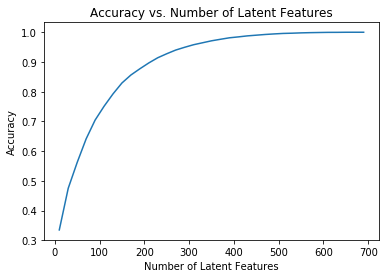

In [19]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for value in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:value]), u[:, :value], vt[:value, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [20]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    #####
    #train_df
    
    #use both filters on user_item_matrix:
    # define unique users from df_train dataset:
    unique_user_train = df_train["user_id"].unique()
    #define unique article_ids from df_train dataset:
    unique_article_train = df_train["article_id"].unique()
    articles = list(unique_article_train)
    #create strings 
    for x in range(0, len(articles)):
        articles[x] = str(articles[x])
    articles
    #use both filters on user_item_matrix:
    #unique users
    user_item_train = user_item_matrix[(user_item_matrix.index.isin(unique_user_train))]
    #unique articles
    user_item_train = user_item_train[[rows for rows in user_item_train.columns if rows in articles]]
    #####
    
    #test_df
    #use both filters on user_item_matrix:
    # define unique users from df_train dataset:
    unique_user_test = df_test["user_id"].unique()
    #define unique article_ids from df_train dataset:
    unique_article_test = df_test["article_id"].unique()
    articles = list(unique_article_test)
    #create strings 
    for x in range(0, len(articles)):
        articles[x] = str(articles[x])
    articles
    #use both filters on user_item_matrix:
    #unique users
    user_item_test = user_item_matrix[(user_item_matrix.index.isin(unique_user_test))]
    #unique articles
    user_item_test = user_item_test[[rows for rows in user_item_test.columns if rows in articles]]
    #####
    
    #define test_idx
    test_idx = list(user_item_test.index)
    #define test_arts
    test_arts = list(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts, unique_user_test, unique_user_train

user_item_train, user_item_test, test_idx, test_arts, unique_user_test, unique_user_train = create_test_and_train_user_item(df_train, df_test)

Response to questions a,b,c and d: 

In [21]:
#Question for a: How many users in the test set are we not able to make predictions for because of the cold start problem?
user_diff = len(np.setdiff1d(user_item_test.index, user_item_train.index))
a = user_diff
a

662

In [22]:
#Question for b:How many movies can we make predictions for in the test set?
movie_test = len(user_item_test.columns)
b = movie_test
b

574

In [23]:
#Question for c: How many users can we make predictions for in the test set?

len_diff = len(test_idx) - user_diff
c = len_diff
c

20

In [24]:
#Question for d: How many movies in the test set are we not able to make predictions for because of the cold start problem?
movie_diff = len(np.setdiff1d(user_item_test.columns, user_item_train.columns))
d = movie_diff
d

0

In [25]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,# letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many movies can we make predictions for in the test set?': b,# letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [26]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [27]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
u_train.shape

(4487, 4487)

In [28]:
s_train.shape

(714,)

In [29]:
vt_train.shape

(714, 714)

In [30]:
# Getting the subset of users within train and test set
users_combined = list(set(unique_user_train) & set(unique_user_test))
len(users_combined)

20

In [32]:
#u_test
user_index = user_item_train.index.isin(test_idx)
u_test = u_train[user_index, :]
#vt-test
vt_index = user_item_train.columns.isin(test_arts)
vt_test = vt_train[:, vt_index]

In [33]:
vt_test.shape

(714, 574)

In [34]:
u_test.shape

(20, 4487)

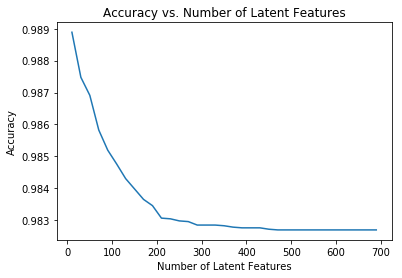

In [35]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new_train, u_new_train, vt_new_train = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_new_test, vt_new_test = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_test_est = np.around(np.dot(np.dot(u_new_test, s_new_train), vt_new_test))
    #user_item_test_est = np.around(np.dot(np.dot(u_test, s_new_train), vt_test))
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test.loc[users_combined],user_item_test_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

The figure that you can see above shows that in total the accuracy of the model is very high. 
However, only 20 are shared among the train data and the test data and the data contains much more zeros than ones. Moreover, 1's and 0's represent an highly imbalanced problem and this can explain the high accuracy value.

In this case here, by increasing the number of latent features, the accuracy decreased. This contradicts the outcome we had found out earlier in part 3. 

To overcome and improve the results, we can do the following:

- re-test it with a bigger test set
- compare the results with different recommendation methods/ models
- perform a A/B experiment.

In practice, I would like to conduct a A/B experiment to determine which one of the recommendation systems should be put into practice. We could do a collaborative filtering model for one group and SVD model for another. The objective is to measure the increase in the number of recommended articles the users are interacting with.

An A/B test approach is a solid setup to understand if the model brings real advantages.


<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [36]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0